In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
%matplotlib inline

In [2]:
game_events_df=pd.read_csv("Football Transfermarkt Project/game_events.csv")
games_df=pd.read_csv("Football Transfermarkt Project/games.csv")
player_vals_df=pd.read_csv("Football Transfermarkt Project/player_valuations.csv")
players_df=pd.read_csv("Football Transfermarkt Project/players.csv")
clubs_df=pd.read_csv("Football Transfermarkt Project/clubs.csv")
competitions_df=pd.read_csv("Football Transfermarkt Project/competitions.csv")

## Data Preparation

In [3]:
competitiondict=dict(zip(competitions_df.competition_id,competitions_df.name))
playersdict=dict(zip(players_df.player_id, players_df.name))
clubsdict=dict(zip(clubs_df.club_id, clubs_df.name))
gameseasondict=dict(zip(games_df.game_id, games_df.season))

### Player Directory

In [4]:
players_df=players_df.replace({"current_club_domestic_competition_id":competitiondict}) 
players_df["sub_position"]=players_df["sub_position"].fillna("Goalkeeper")

In [5]:
player=players_df[players_df["name"]=="Craig Bellamy"]

### Player Valuation History

In [6]:
player_vals_df=player_vals_df.replace({"player_id":playersdict})

In [7]:
player_vals_df=player_vals_df.replace({"current_club_id":clubsdict})

In [8]:
player_vals_df=player_vals_df.replace({"player_club_domestic_competition_id":competitiondict})

In [9]:
player_vals_df["season"]=player_vals_df["date"].str[:4]

### Game Dataset

In [10]:
games_df=games_df.replace({"competition_id":competitiondict})

### Player Performance Log (Goals)

In [11]:
gamecompetitiondict=dict(zip(games_df.game_id,games_df.competition_id))

In [12]:
goals_df=game_events_df[game_events_df["type"]=="Goals"]

In [13]:
goals_df["season"]=goals_df["game_id"]
goals_df["competition"]=goals_df["game_id"]

<ipython-input-13-019b8b882f0c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  goals_df["season"]=goals_df["game_id"]
<ipython-input-13-019b8b882f0c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  goals_df["competition"]=goals_df["game_id"]


In [14]:
goals_df=goals_df.replace({"player_id":playersdict})

In [15]:
goals_df=goals_df.replace({"club_id":clubsdict})

In [16]:
goals_df=goals_df.replace({"season":gameseasondict})

In [17]:
goals_df=goals_df.replace({"competition":gamecompetitiondict})

## Data Exploration

### Most Expensive Nationalities

In [18]:
nationalities=list(players_df["country_of_citizenship"].unique())

nationalities_values={}
nationalities_counts={}

for i in nationalities:
    nationalitiesdf=players_df[players_df["country_of_citizenship"]==i]
    nationalitiesdf=nationalitiesdf.dropna(subset=["market_value_in_eur"])
    nationalitiesdf["market_value_in_eur"]=nationalitiesdf["market_value_in_eur"].astype(int)
    average_player_value=nationalitiesdf["market_value_in_eur"].mean()
    if math.isnan(average_player_value):
        nationalities_values[i]=0
        nationalities_counts[i]=0
    else:
        average_player_value=round(average_player_value)
        nationalities_values[i]=average_player_value
        nationalitiesdf=nationalitiesdf.drop_duplicates(subset="name", keep="first")
        count=len(nationalitiesdf)
        nationalities_counts[i]=count

In [19]:
def remove_keys_with_value(d, value):
    """
    Removes all keys from a dictionary 'd' that have the given value.
    """
    keys_to_remove = []
    for key, val in d.items():
        if val <= value:
            keys_to_remove.append(key)
    for key in keys_to_remove:
        del d[key]
    return d

In [20]:
nationalities_values=remove_keys_with_value(nationalities_values, 50)
nationalities_counts=remove_keys_with_value(nationalities_counts, 50)

nationalities=nationalities_counts.keys()

In [21]:
valuesdf=pd.DataFrame()
valuesdf["Nationalities"]=nationalities
valuesdf["Average_Market_Value"]=nationalities
valuesdf["Player_Count"]=nationalities

valuesdf=valuesdf.replace({"Average_Market_Value": nationalities_values})
valuesdf=valuesdf.replace({"Player_Count": nationalities_counts})

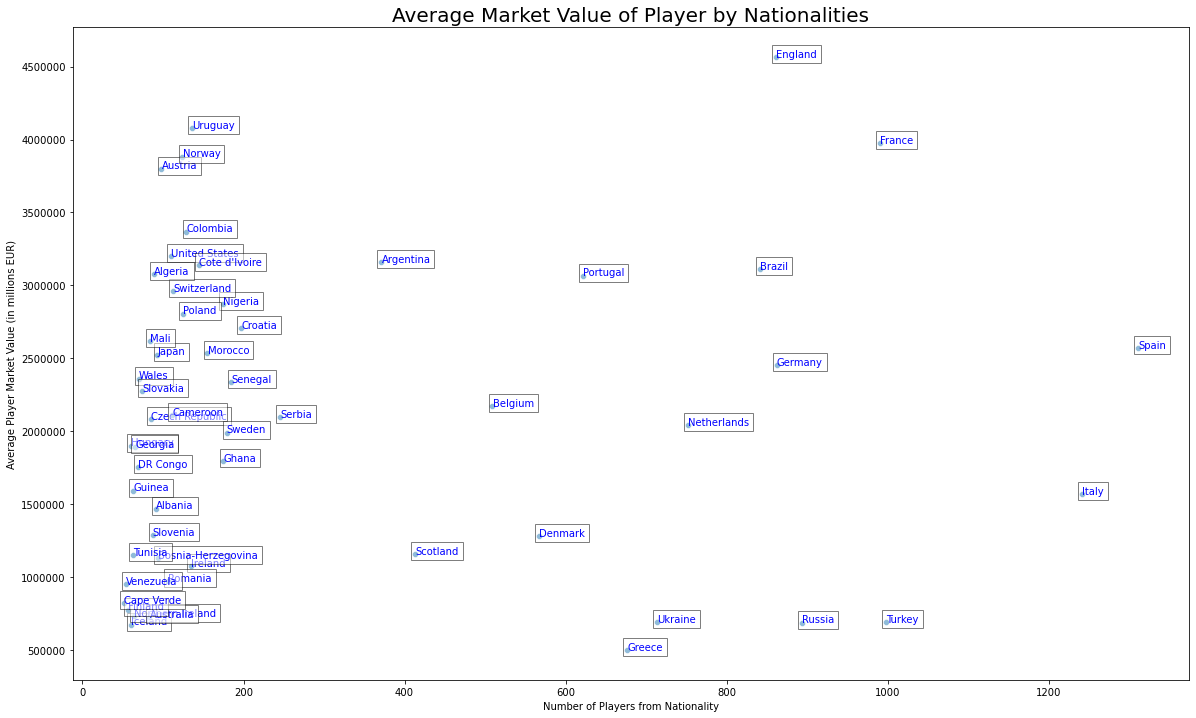

In [22]:
plt.figure(figsize=(20,12))

sns.scatterplot(data=valuesdf, x="Player_Count", y="Average_Market_Value")
plt.title("Average Market Value of Player by Nationalities", size=20)
plt.xlabel("Number of Players from Nationality")
plt.ylabel("Average Player Market Value (in millions EUR)")
plt.ticklabel_format(axis="y",style="plain")


for i in range(valuesdf.shape[0]):
 plt.text(x=valuesdf.Player_Count[i]+0.3,y=valuesdf.Average_Market_Value[i]+0.3,s=valuesdf.Nationalities[i], 
          fontdict=dict(color="b",size=10),
          bbox=dict(facecolor="w",alpha=0.5))

### Player Valuation History

In [23]:
def valuation_history(player):
    playervaldf=player_vals_df[player_vals_df["player_id"]==player]
    nationality=players_df[players_df["name"]==player].iat[0,4]
    position=players_df[players_df["name"]==player].iat[0,9]
    current_club=players_df[players_df["name"]==player].iat[0,3]
    foot=players_df[players_df["name"]==player].iat[0,10]
    height=players_df[players_df["name"]==player].iat[0,11]
    age=2023-int(players_df[players_df["name"]==player].iat[0,7][:4])
    
    x=playervaldf["season"]
    y=playervaldf["market_value_in_eur"]
    
    fig,ax=plt.subplots(figsize=(12,8))
    g=plt.bar("season", "market_value_in_eur", data=playervaldf)
    
    text=' '.join((" Position: ", str(position),"\n","Age: ", str(age),"\n","Current Club: ", str(current_club),"\n","Nationality: ", str(nationality),"\n","Preferred Foot: ", str(foot), "\n", "Height: ", str(height), "cm"))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    
    ax.ticklabel_format(axis="y",style="plain")
        
    plt.title(f"{player} Valuation History", size=20)
    plt.xlabel("Seasons", size=15)
    plt.ylabel("Market Valuation (in Euros)", size=15)
    plt.text(1.025, 0.95, text, fontsize=15, bbox=props, ha="left", va="top", transform=ax.transAxes)


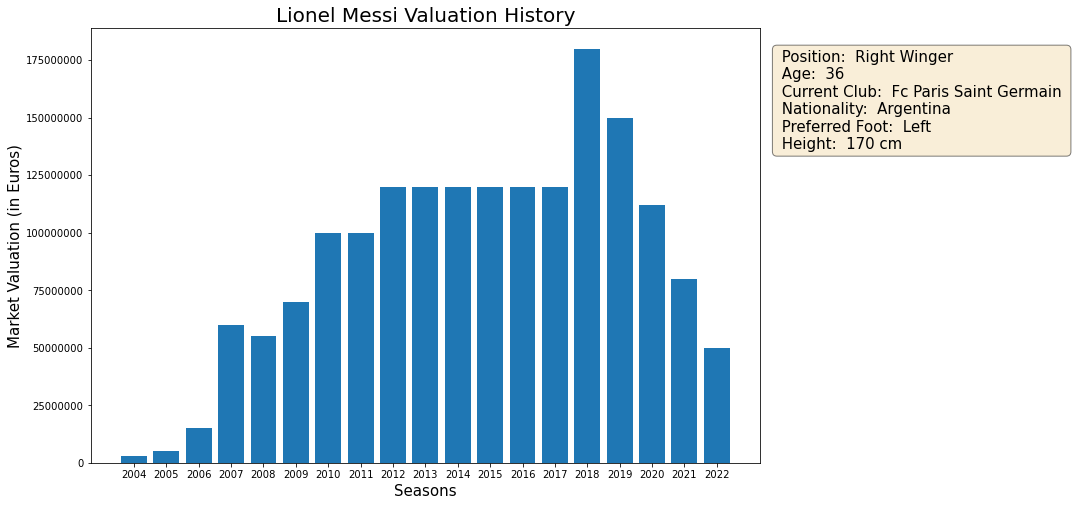

In [24]:
valuation_history("Lionel Messi")

### Evolution of League Player Values

In [25]:
seasons=sorted(list(player_vals_df["season"].unique()))[:-1]
leagues=list(player_vals_df["player_club_domestic_competition_id"].unique())

In [26]:
league_vals_df=pd.DataFrame(index=leagues)

In [27]:
for season in seasons:
    playerseasonval=player_vals_df[player_vals_df["season"]==season]
    playersbyleague=round(playerseasonval.groupby(["player_club_domestic_competition_id"]).mean())
    leaguevaldict=playersbyleague.to_dict()
    leaguevaldict=leaguevaldict["market_value_in_eur"]
    for league in leagues:
        if league not in leaguevaldict.keys():
            leaguevaldict[league]=0
    league_vals_df[season]=leagues
    league_vals_df=league_vals_df.replace({season:leaguevaldict})

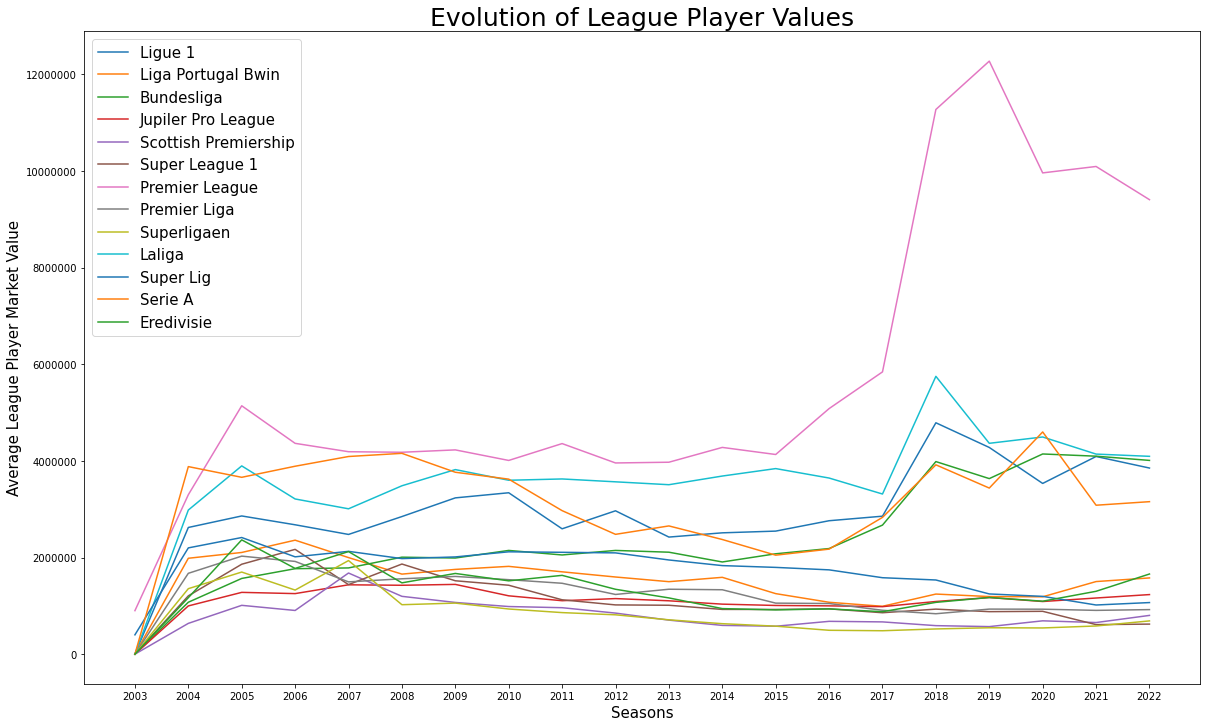

In [28]:
plt.figure(figsize=(20,12))
for league in leagues:
    plt.plot(seasons, league_vals_df.loc[league], label=str(league))

plt.xlabel("Seasons", size=15)
plt.ylabel("Average League Player Market Value", size=15)
plt.ticklabel_format(axis="y",style="plain")
plt.title("Evolution of League Player Values", size=25)
plt.legend(fontsize=15)